In [1]:
import xgboost as xgb
from xgboost import XGBClassifier,XGBRFClassifier
import time
import matplotlib.pyplot as plt
from scipy.io import loadmat
import numpy as np

In [114]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,StratifiedKFold,\
    cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [62]:
# Function to print shape of variables
def s(*arg):
    d=[]
    for i in arg:
        d.append(np.shape(i))
    print(*d, sep=" ")

# import 8x8 dataset

In [63]:
numbers = load_digits()
X = numbers.data
y = numbers.target
#ADD SOME NOISE HERE!!
print(np.min(X),np.max(X),np.min(y),np.max(y)) #these should be standardized then.

0.0 16.0 0 9


# split into train test (no val, as im using cv or bootstrap)

In [64]:
test_size=0.2
X_train_,X_test_,y_train,y_test = train_test_split(X,y,test_size=test_size,random_state=2,shuffle=True,stratify=y)

# scale data

In [65]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train_)
X_test = sc.transform(X_test_)

# XGBClassifier

In [105]:
#DO THESE CONVERT INPUT TO DMatrix?
#THIS IS GRADIENT BOOSTING; NOT RANDOM FOREST
xgbc = XGBClassifier()
xgbc.fit(X_train,y_train)
scores=cross_val_score(xgbc,X_train,y_train,cv=5)
print("CV:",scores.mean())
print("test acc",xgbc.score(X_test,y_test))

CV: 0.9553945993233649
test acc 0.9583333333333334


# XGBRFClassifier

In [107]:
#why is this horrible? tune params
ting={'eval_metric':'merror'}
xgbrfc = XGBRFClassifier(random_state=4,objective='multi:softmax',num_class=10,**ting)
xgbrfc.fit(X_train,y_train)
scores=cross_val_score(xgbrfc,X_train,y_train,cv=5)
print("CV:",scores.mean())
print("test acc:",xgbrfc.score(X_test,y_test))

CV: 0.8928052696948242
test acc: 0.8722222222222222


# DecisionTreeClassifier

In [108]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(max_depth=None,min_samples_split=2,random_state=3)
dtc.fit(X_train,y_train)
scores=cross_val_score(xgbc,X_train,y_train,cv=5)
print("CV:",scores.mean())
print("test acc:",dtc.score(X_test,y_test))

CV: 0.9553945993233649
test acc: 0.8388888888888889


# RandomForestClassifier

In [109]:
rfc = RandomForestClassifier(n_jobs=-1,n_estimators=1000,bootstrap=True,criterion='gini',random_state=3)
rfc.fit(X_train,y_train)
scores=cross_val_score(rfc,X_train,y_train,cv=5)
print("CV:",scores.mean())
print("Accuracy with gini:   ",rfc.score(X_test,y_test))

rfc = RandomForestClassifier(n_jobs=-1,n_estimators=1000,bootstrap=True,criterion='entropy',random_state=3)
rfc.fit(X_train,y_train)
scores=cross_val_score(rfc,X_train,y_train,cv=5)
print("CV:",scores.mean())
print("Accuracy with entropy:",rfc.score(X_test,y_test))

CV: 0.9707389894805752
Accuracy with gini:    0.9777777777777777
CV: 0.971438290179876
Accuracy with entropy: 0.9777777777777777


# extremely randomized trees

In [110]:
from sklearn.ensemble import ExtraTreesClassifier

ert = ExtraTreesClassifier(n_estimators=1000,max_depth=None,min_samples_split=2,random_state=3)
ert.fit(X_train,y_train)
scores=cross_val_score(ert,X_train,y_train,cv=5)
print("CV:",scores.mean())
print("Accuracy:",ert.score(X_test,y_test))

CV: 0.9790754303326545
Accuracy with entropy: 0.9861111111111112


# bagging meta-estimator

In [123]:
from sklearn.ensemble import BaggingClassifier
bcl = BaggingClassifier(n_estimators=60,max_samples=1.0,bootstrap_features=True,random_state=3)
bcl.fit(X_train,y_train)
scores=cross_val_score(bcl,X_train,y_train,cv=5)
print("CV:",scores.mean())
print("accuracy",bcl.score(X_test,y_test))

CV: 0.9708043134077528
accuracy 0.9722222222222222


# GradientBoostingClassifier

In [121]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=100,learning_rate=1.0,max_depth=4,random_state=3)
gbc.fit(X_train,y_train)
scores=cross_val_score(gbc,X_train,y_train,cv=5)
print("CV:",scores.mean())
print("accuracy",gbc.score(X_test,y_test))

CV: 0.6070648919194304
accuracy 0.9111111111111111


# Adaboost

In [122]:
from sklearn.ensemble import AdaBoostClassifier
adb = AdaBoostClassifier(random_state=3,n_estimators=1000,learning_rate=0.1)
adb.fit(X_train,y_train)
scores=cross_val_score(ert,X_train,y_train,cv=5)
print("CV:",scores.mean())
print("Accuracy:",adb.score(X_test,y_test))

CV: 0.9790754303326545
Accuracy: 0.7444444444444445


# other stuff below

In [ ]:
clf = XGBRFClassifier(random_state=3)
opt_dict={
    'n_estimators':[10,100,1000,2000],
    'learning_rate':np.logspace(-5,1,7),  
}
mod = GridSearchCV(clf,opt_dict,scoring='accuracy',verbose=1,cv=5,n_jobs=-1)
mod.fit(X_train,y_train)
print(mod.best_score_)
print(mod.best_params_)

# XGBtrain

0.9583333333333334


<Figure size 432x288 with 0 Axes>

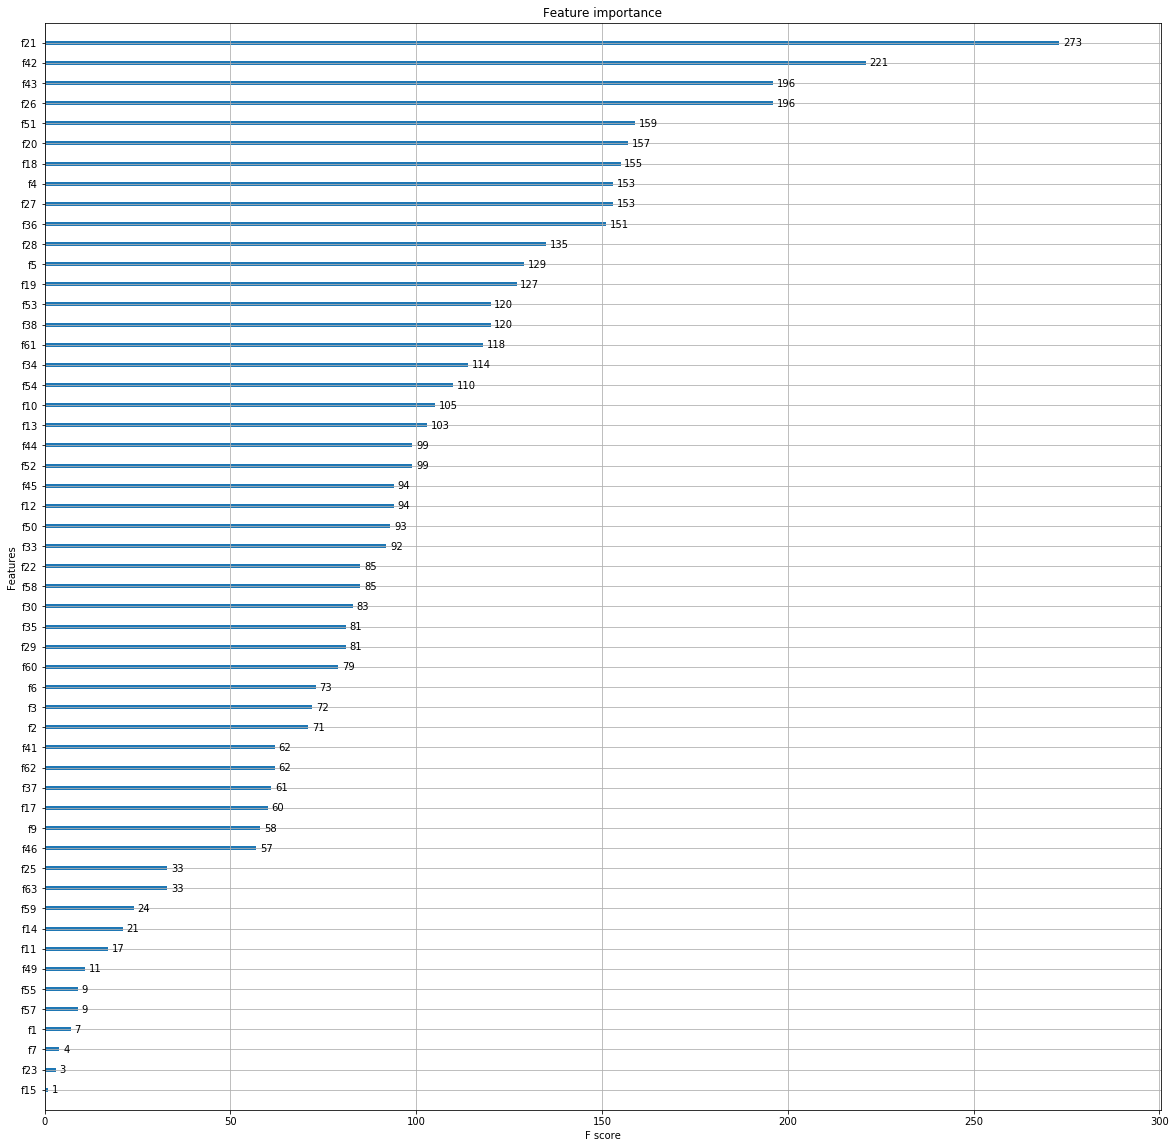

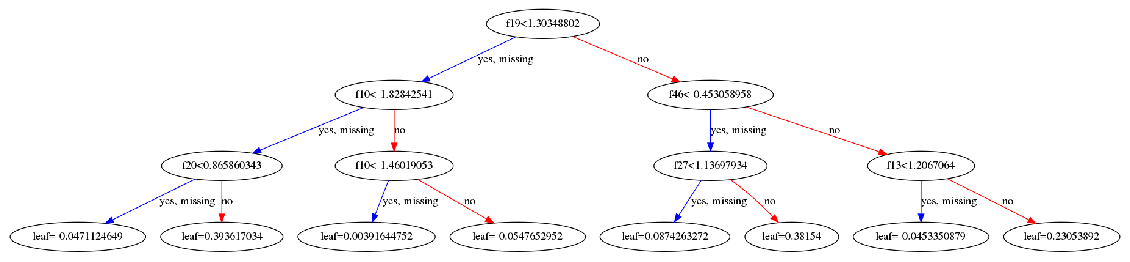

In [10]:
# when using xgboost, the data should be put into a Data Matrix structure, seen in
# https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.DMatrix
D_train = xgb.DMatrix(X_train,label=y_train)
D_test = xgb.DMatrix(X_test,label=y_test)
classifier_params = {
    'eta':0.1,
    'max_depth':3,
    'objective':'multi:softmax',
    'num_class':10,
}
# evallist=[(D_test,'test'),(D_train,'train')]
evallist=[(D_train,'train'),(D_test,'test')]

num_round=100
early_stopping=10


bst=xgb.train(classifier_params,D_train,num_round,evallist,early_stopping_rounds=early_stopping,verbose_eval=False)
y_pred=bst.predict(D_test)
print(accuracy_score(y_test,y_pred))

plt.figure()
fig,ax = plt.subplots(figsize=(20,20))

xgb.plot_importance(bst,ax=ax)
plt.show()

fig,ax = plt.subplots(figsize=(20,20))
xgb.plot_tree(bst,num_trees=1,ax=ax)

In [11]:
xgb_model = XGBClassifier()
opt_dict={
    'max_depth':[2,3,4],
    'eta': np.logspace(-3,1,5),
    'lambda': np.logspace(-7,1,8),
    'alpha':np.logspace(-7,1,8),
}
mod = GridSearchCV(xgb_model,opt_dict,scoring='accuracy',verbose=1,cv=5,n_jobs=-1)
mod.fit(X_train,y_train)
print(mod.best_score_)
print(mod.best_params_)

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 29.1min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 37.1min
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed: 44.1min finished


0.9624217118997912
{'alpha': 1e-07, 'eta': 0.001, 'lambda': 1e-07, 'max_depth': 4}


In [12]:
xgb_model = XGBRFClassifier()
opt_dict={
    'max_depth':[2,3,4],
    'eta': np.logspace(-3,1,5),
    'lambda': np.logspace(-7,1,8),
    'alpha':np.logspace(-7,1,8),
}
mod = GridSearchCV(xgb_model,opt_dict,scoring='accuracy',verbose=1,cv=5,n_jobs=-1)
mod.fit(X_train,y_train)
print(mod.best_score_)
print(mod.best_params_)

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 24.3min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 30.7min
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed: 36.4min finished


0.9199721642310369
{'alpha': 1e-07, 'eta': 0.001, 'lambda': 1e-07, 'max_depth': 4}


In [29]:
param = mod.best_params_
param['lambda']=0
param['alpha']=0

xgb_model = XGBRFClassifier(**param,random_state=4,num_rounds=300,verbose_eval=0)
xgb_model.fit(X_train,y_train)
y_p = xgb_model.predict(X_test)
print(accuracy_score(y_p,y_test))
# param = mod.best_params_
# mod2 = XGBRFClassifier(param, X_test,y_test)


# model = XGBRFClassifier(random_state=4)
# model.fit(X_train,y_train)
# y_pred_rfc = model.predict(X_test)
# print(accuracy_score(y_test,y_pred_classifier))

0.9027777777777778


In [ ]:
max_iters = 1000
start = time.time()
for i in range(max_iters):
    xgb.train(dtrain=D_train,params=prams)
print("dmatrix method took {}s".format(time.time()-start))

In [ ]:
# test timestuff
    max_iters = 1000
start = time.time()
for i in range(max_iters):
    model.fit(X_train,y_train)
#     xgb.train(dtrain=D_train,params=prams)
print("train method took {}s".format(time.time()-start))

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix
ape = confusion_matrix(y_pred,y_test)
df = pd.DataFrame(ape)

np.fill_diagonal(df.values,0)
ultros=np.max(np.max(df))
np.fill_diagonal(df.values,ultros)

print(ultros)
display(df)
ax = sns.heatmap(df,)
bottom,top =ax.get_ylim()
ax.set_ylim(bottom+0.5,top-0.5)
plt.show()

In [ ]:
num = 7
plt.imshow(X_train[num,:].reshape(8,8),cmap='gray_r')
print("This is a:",y_train[num])
print("Predicted as a:",int(y_pred[num]))

In [ ]:
# from sklearn.datasets import fetch_mldata,fetch_openml
# # mnist = fetch_mldata('MNIST original', data_home=custom_data_home)
# mnist=fetch_openml('mnist_784')
# #This is very slow!

In [ ]:
# Xf = mnist.data
# uf = mnist.target
# print(np.shape(Xf))

In [ ]:
from scipy.io import loadmat
data = loadmat('mnist-original.mat')
X_full = data['data'].T
y_full = np.squeeze(data['label'].T)

In [ ]:
test_size=0.2
X_ftrain,X_ftest,y_ftrain,y_ftest = train_test_split(X_full,y_full,test_size=test_size,random_state=2)#,stratify=y)
# train_test_split(X_full,y_full,test_size=test_size);

In [ ]:
model = XGBClassifier()
model.fit(X_ftrain,y_ftrain)
y_pred_classifier = model.predict(X_ftest)
print(accuracy_score(y_test,y_pred_classifier))

In [ ]:
# when using xgboost, the data should be put into a Data Matrix structure, seen in
# https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.DMatrix
D_ftrain = xgb.DMatrix(X_ftrain,label=y_ftrain)
D_ftest = xgb.DMatrix(X_ftest,label=y_ftest)
params_XGBClassifier = {
    'booster':'gbtree',    
    'eta':0.1,
    'max_depth':3,
    'lambda':1,
    'objective':'multi:softmax',
    'num_class':10,
}
evallist=[(D_ftest,'test'),(D_ftrain,'train')]
num_round=100
stopping_rounds = 10
max_depth = 5
# evals_result={}

bst = xgb.train(params_XGBClassifier,D_ftrain,num_round,evallist,early_stopping_rounds=stopping_rounds)#,verbose_eval=False)

In [ ]:
y_fpred = bst.predict(D_ftest)

print(accuracy_score(y_ftest,y_fpred))
# plt.figure()
fig,ax = plt.subplots(figsize=(20,20))

xgb.plot_importance(bst,ax=ax)
plt.show()

fig,ax = plt.subplots(figsize=(20,20))
xgb.plot_tree(bst,num_trees=0,ax=ax)
plt.show()

In [ ]:
params_optimizing = {
    'booster':'gbtree',    
    'eta':0.9,
    'max_depth':2,
    'lambda':1,
    'objective':'multi:softmax',
    'num_class':10,
}
evallist=[(D_ftest,'test'),(D_ftrain,'train')]
num_round=100
stopping_rounds = 10
max_depth = 5

bst = xgb.train(params_optimizing,D_ftrain,num_round,evallist,early_stopping_rounds=stopping_rounds)#,verbose_eval=False)

In [ ]:
y_pred =bst.predict(D_ftest)
print(np.shape(y_pred),np.shape(y_ftest))

In [ ]:
ape = confusion_matrix(y_pred,y_ftest)
df = pd.DataFrame(ape)
ultros=np.maximum(ape)
# np.fill_diagonal(df.values,0)
display(df)
ax = sns.heatmap(df)
bottom,top =ax.get_ylim()
ax.set_ylim(bottom+0.5,top-0.5)
plt.show()

In [ ]:
# xgb_model = RandomForestClassifier(random_state=3)
# opt_dict={
#     'max_depth':[2,3,4,5,6,7,8,9,10,11,12],
#     'n_estimators':[10,100,1000,2000],
# }
# mod = GridSearchCV(xgb_model,opt_dict,scoring='accuracy',verbose=1,cv=5,n_jobs=-1)
# mod.fit(X_train,y_train)
# print(mod.best_score_)
# print(mod.best_params_)